# Processing SEM images of mouse mPFC with synapse segmentations

## goal: to train a classifier + cycleGAN do knoweldge extraction on SEM images of two conditions: 1). mice treated with a drug (D); 2). mice treated with vehicle (V)

pre-processing:

1. find out the centroids of each synapse based on ground truth segmentations
2. find out the global maximum bounding ecllipse radius of all synapses
3. use the centroids and global (0.75 quantile) maximum radius above to caculate a crop box (2D) for each synapse (with the synapse centered)
4. since the crops might fall beyond the image dimensions, a padding was created around the raw images
5. crop the images and saved them somewhere

In total, about ~250 synapse images per block (n=6) per animal (n=6). Sums to about 9000 cropped images of synapses of the same size.


In [ ]:
# important notes to do after classification:

## some image crops contain paddings
## if classifier doesn't work (with shift augmentation), 
## first thing to try is to remove crops that contain the paddings ("try: except error"...?)

In [681]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.measure import regionprops
import os
from skimage.io import imread, imsave
from skimage import segmentation
import csv
import random
import scipy.stats as stats
import glob
from natsort import natsorted

In [44]:
train_path = "/Users/yuningwang/Desktop/DLMBL_data/synapse/train/"

In [590]:
path = "/Users/yuningwang/Desktop/DLMBL_data/synapse/train/F1V/block89/raw"
files = natsorted(glob.glob(os.path.join(path, "*.tif")))
n = 0
#for f in files:
    if n > 9:
        src = f
        dst = os.path.join(path, "raw_" + str(n) + ".tif")
        #print([n, dst])
        os.rename(src, dst)
    n += 1
    

[10, '/Users/yuningwang/Desktop/DLMBL_data/synapse/train/F1V/block89/raw/raw_10.tif']
[11, '/Users/yuningwang/Desktop/DLMBL_data/synapse/train/F1V/block89/raw/raw_11.tif']
[12, '/Users/yuningwang/Desktop/DLMBL_data/synapse/train/F1V/block89/raw/raw_12.tif']
[13, '/Users/yuningwang/Desktop/DLMBL_data/synapse/train/F1V/block89/raw/raw_13.tif']
[14, '/Users/yuningwang/Desktop/DLMBL_data/synapse/train/F1V/block89/raw/raw_14.tif']
[15, '/Users/yuningwang/Desktop/DLMBL_data/synapse/train/F1V/block89/raw/raw_15.tif']
[16, '/Users/yuningwang/Desktop/DLMBL_data/synapse/train/F1V/block89/raw/raw_16.tif']
[17, '/Users/yuningwang/Desktop/DLMBL_data/synapse/train/F1V/block89/raw/raw_17.tif']
[18, '/Users/yuningwang/Desktop/DLMBL_data/synapse/train/F1V/block89/raw/raw_18.tif']
[19, '/Users/yuningwang/Desktop/DLMBL_data/synapse/train/F1V/block89/raw/raw_19.tif']
[20, '/Users/yuningwang/Desktop/DLMBL_data/synapse/train/F1V/block89/raw/raw_20.tif']
[21, '/Users/yuningwang/Desktop/DLMBL_data/synapse/tra

In [670]:
block_paths = []

for a in natsorted(os.listdir(train_path)):
    if a != '.DS_Store':
        animal_path = os.path.join(train_path, a)
        for b in natsorted(os.listdir(animal_path)):
            if b != '.DS_Store':
                block_path = os.path.join(animal_path, b)
                block_paths.append(block_path)


In [680]:
# make new crops directories

#for i in block_paths:
    files = glob.glob(os.path.join(i, "*"))
    dirs = os.listdir(i)
    
    if "crops" not in dirs:
        print('no crops dir')
        os.mkdir(os.path.join(i, "crops"))
        #print(os.path.join(i, "crops"))

no crops dir
no crops dir
no crops dir
no crops dir
no crops dir
no crops dir
no crops dir
no crops dir
no crops dir
no crops dir
no crops dir
no crops dir
no crops dir
no crops dir
no crops dir
no crops dir
no crops dir
no crops dir
no crops dir
no crops dir
no crops dir
no crops dir
no crops dir
no crops dir
no crops dir
no crops dir
no crops dir
no crops dir
no crops dir
no crops dir
no crops dir
no crops dir
no crops dir
no crops dir
no crops dir
no crops dir


In [66]:
# to change filenames
#for i in os.listdir(train_path):
    if i != ".DS_Store":
        block_ls = os.listdir(os.path.join(train_path, i))
        for j in block_ls:
            if j != ".DS_Store":
                raw_path = os.path.join(train_path, i, j, "raw")
                for x in glob.glob(os.path.join(raw_path, "*")):
                    src = x
                    dst = x + ".tif"
                    os.rename(src, dst)

In [321]:
# change the name of the raw file
ls = os.listdir(os.path.join(train_path, "F24D"))
#for i in natsorted(ls):
    if i != ".DS_Store":
            raw_path = os.path.join(train_path, "F24D", i, "raw")
            #print(raw_path)
            
            
            raw_imgs = [i for i in natsorted(glob.glob(os.path.join(raw_path, "*")))]
            n = 0
            #print(raw_imgs)
            #print(len(raw_imgs))
            assert ".DS_Store" not in raw_imgs
            assert "Thumbs.db" not in raw_imgs
            for x in raw_imgs:
                src = x
                if n < 10:
                    dst = os.path.join(raw_path, "raw_0" + str(n) + ".tif")
                else:
                    dst = os.path.join(raw_path, "raw_" + str(n) + ".tif")
                os.rename(src, dst)
                n += 1
                #print(src, dst)
                #assert src == dst

In [188]:
def read_label(label_path): 
    
    label_paths = natsorted(glob.glob(label_path)) # returns a list of file pathnames
    syn_labels = [imread(z) for z in label_paths] # a list containing imread ndarrays for all stacks in an EM block
    syn_label_array = np.array(syn_labels) # convert the list of stacks into an array for the EM block
    
    # imported images should have a shape (in voxel) of [55, 375, 375] 
    # but some ground truth blocks have a shape of [56, 376, 376]...?
    
    if syn_label_array.shape != (55, 375, 375):
        syn_label_array = syn_label_array[:55, :375, :375]
        
    #cleared_syn_label_array = clear_border_labels(syn_label_array)
        
    # create a boolean mask (of the same shape of the label array) that filter out background (values of 0) 
    # this mask is used to calculate label volume later
    
    syn_label_mask = syn_label_array != 0 
    
    return syn_label_array, syn_label_mask # needs to pack to access individual values later

In [591]:
animals = ["F1V", "F2D", "F7V", "F8D", "F23V", "F24D"]
max_rads = []

for animal in animals:
    animal_path = os.path.join(train_path, animal)
    blocks = os.listdir(animal_path)
    blocks = [i for i in natsorted(blocks) if i != ".DS_Store" and i != "Thumbs.db"]
    
    for block in blocks:
        array, mask = read_label(os.path.join(train_path, animal, block, "labels", "*.tif"))        
        block_centroids = []
        
        for z in range(len(array)):
            z_centroids = []
            relabel = skimage.measure.label(array[z])
            regions = regionprops(relabel)
            #z_format = os.path.join(train_path, animal, block, "labels"
        
            for props in regions:
                y, x = props.centroid
                z_centroids.append([x, y, z])
                max_rad = props.axis_major_length
                area = props.area
                max_rads.append([animal, block, z, x, y, max_rad, area])
        

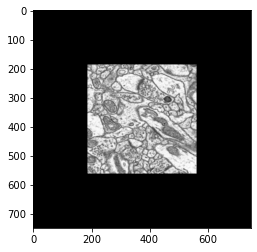

In [603]:
# show an cropped image using 

img = imread(os.path.join(train_path, "F1V", "block6", "raw", "raw_00.tif"))

# row length, column length
x1 = centroids[0][0] - bbox[0][0]
x2 = centroids[0][0] + bbox[0][0]
y1 = centroids[0][1] - bbox[0][0]
y2 = centroids[0][1] + bbox[0][0]

pad_width = int(375/2)
patch_pad = 5 #for creating a slightly larger patch 
img_padded = np.pad(img, pad_width=int(375/2))

padded_x1 = int(x1) + pad_width
padded_x2 = int(x2) + pad_width
padded_y1 = int(y1) + pad_width
padded_y2 = int(y2) + pad_width

crop_og = img[int(y1)-patch_pad:int(y2+1)+patch_pad+1, int(x1)-patch_pad:int(x2)+patch_pad+1]
crop_new = img_padded[(padded_y1-patch_pad):(padded_y2+patch_pad+1), (padded_x1-patch_pad):(padded_x2+patch_pad+1)]

plt.imshow(img_padded, cmap='gray')

In [753]:
centroid_df = pd.DataFrame(max_rads, columns=['animal', 'block', 'z', 'x', 'y', 'max_rad', 'area'])
#max(centroid_df.area)

F2D_df = centroid_df[centroid_df['animal']=='F2D']

F2D_block6_df = F2D_df[F2D_df['block']=='block23']
F2D_block6_df

,animal,block,z,x,y,max_rad,area
2472,F2D,block23,0,321.239130,6.021739,31.795852,138
2473,F2D,block23,0,165.721739,79.791304,30.745604,115
2474,F2D,block23,0,328.500000,111.000000,64.403137,308
2475,F2D,block23,0,277.572816,175.029126,26.001492,103
2476,F2D,block23,0,214.376000,174.584000,44.581309,250
...,...,...,...,...,...,...,...
2694,F2D,block23,54,154.191176,6.794118,17.472755,68
2695,F2D,block23,54,215.342105,98.868421,46.627666,190
2696,F2D,block23,54,42.754717,155.402516,35.117954,159
2697,F2D,block23,54,302.385321,209.114679,50.073655,218


In [781]:
def crop_image(df, max_rad, path=train_path, pad_width=int(375/2), patch_pad=5):

    for a in animals[1:2]:
        animal_df = df[df['animal']==a]
        blocks = list(animal_df.block.unique())
            
        for b in blocks[4:5]:
            img_crops = []
            block_df = animal_df[animal_df['block']==b]
            
            for idx in block_df.index:

                row = block_df.loc[idx]
                x = row.x  #seg centroid x coord
                y = row.y  #seg centroid y coord

                x1 = int(x - max_rad - patch_pad) # get the bounding box by centroid and max bounding ecllipse radius
                x2 = int(x + max_rad + patch_pad + 1)
                y1 = int(y - max_rad - patch_pad)
                y2 = int(y + max_rad + patch_pad + 1)

                z = row.z
                
                raw_dir = natsorted(os.listdir(os.path.join(path, a, b, "new_raw")))
                img_name = raw_dir[z]
                
                img_path = os.path.join(path, a, b, "new_raw", img_name)
                img = imread(img_path)
                img_padded = np.pad(img, pad_width)

                padded_x1 = x1 + pad_width
                padded_x2 = x2 + pad_width
                padded_y1 = y1 + pad_width
                padded_y2 = y2 + pad_width

                img_crop = img_padded[padded_y1:padded_y2, padded_x1:padded_x2]
                img_crops.append([z, img_crop])

            n = 0
            for c in img_crops:

                fname = "z" + str(c[0]) + "_" + str(n) + ".tif" # format = zx_y.tif (x = z stack, y = synapse)
                save_path = os.path.join(path, a, b, "crops", fname)
                imsave(save_path, c[1])
                n += 1

In [782]:
rad_3rdq = np.quantile(centroid_df.max_rad, 0.75) # current maxium radius is set to the 3rd quantile of all max radius

crop_image(df=centroid_df, max_rad=rad_3rdq)

F7V block32 54


Text(0.5, 1.0, 'F7Vblock32 at z=54')

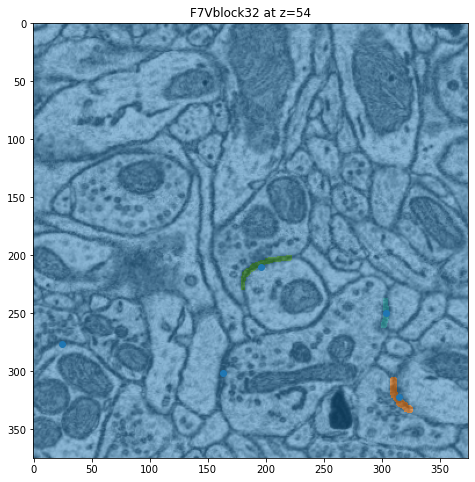

In [791]:
# randomly check one image and its segmentation / centroid
rand_row = centroid_df.sample()
z = rand_row.at[rand_row.index[0], 'z']
animal = rand_row.at[rand_row.index[0], 'animal']
block = rand_row.at[rand_row.index[0], 'block']

animal_all = centroid_df[centroid_df['animal']==animal]
block_all = animal_all[animal_all['block']==block]

xs = {}
ys = {}

for z in block_all.z.unique():
    z_stack = block_all[block_all['z']==z]
    x = list(z_stack.x)
    y = list(z_stack.y)
    xs[z] = x
    ys[z] = y

print(animal, block, z, )


#if z < 10:
 #   img = f"raw_0{z}.tif"
  #  seg = f"seg_0{z}.tif"
#else:
 #   img = f"raw_{z}.tif"
  #  seg = f"seg_{z}.tif"
    
raw_dir = natsorted(os.listdir(os.path.join(train_path, animal, block, "raw")))
img_name = raw_dir[z]
    
a = imread(os.path.join(train_path, animal, block, "raw", img))
b = imread(os.path.join(train_path, animal, block, "labels", seg))

plt.figure(figsize=[8, 8])
plt.imshow(a, cmap='gray')
plt.scatter(xs[z], ys[z])
plt.imshow(b, alpha=0.5, cmap='tab10', interpolation='none')
plt.title(animal + block + " at z=" + str(z))